In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
%matplotlib inline
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from numpy import sqrt, cos, sin, pi
from numpy.fft import fft, ifft, rfft, irfft
from tqdm import tqdm
import time
import h5py
import torch
torch.cuda.empty_cache()

### Generate data

In [3]:
filename = '/home/u00u55a90laDwpF5Bs357/plasma_closure/data_2d_001.h5'

In [4]:
def read_T_q(filename, nsamples=None):
    with h5py.File(filename, 'r') as file:
        print([k for k in file])
        print('full data shape', file['Txx1'].shape)
        Txx = file['Txx1'][slice(nsamples), ...]
        Txy = file['Txy1'][slice(nsamples), ...]
        q = file['qxxy'][slice(nsamples), ...]
        return Txx, Txy, q
    
def normalize(arr):
    # all data have mean=0
    # XXX use the same max
    return arr / abs(arr).max()

In [5]:
num = 1000
Txx, Txy, q = read_T_q(filename, num)
Txx.shape, q.shape
nsamples, nx, ny = Txx.shape  # FIXME nx, ny order?

T = np.empty((num, 2, 256, 256))
T[:, 1, ...] = Txx
T[:, 1, ...] = Txy

['Txx1', 'Txy1', 'qxxy', 'x', 'y']
full data shape (10000, 256, 256)


In [9]:
q = q.reshape((nsamples, 1, nx, ny))
T = normalize(T)
q = normalize(q)

test_split = 0.05
nsamples_test = int(nsamples * test_split)
nsamples_train = nsamples - nsamples_test

import torch
train_data = torch.tensor(T[:nsamples_train, ...])
train_labels = torch.tensor(q[:nsamples_train, ...])

test_data = torch.tensor(T[nsamples_train:, ...])
test_labels = torch.tensor(q[nsamples_train:, ...])

print(train_data.shape)
print(train_labels.shape)

train_set = torch.utils.data.TensorDataset(
    # TODO: how to load multiple inputs/labels
    train_data, train_labels)

test_set = torch.utils.data.TensorDataset(
    # TODO: how to load multiple inputs/labels
    test_data, test_labels)

#cache
#cache = Cache(load_file, memory_cap = 80)

trainloader = torch.utils.data.DataLoader(train_set,  # TensorDataset
                                         # batch_size=64,  # feed a batch per time
                                          shuffle=False,  # shuffle the order of sets
                                          num_workers=2,  # multi-process data loading
                                         )
testloader = torch.utils.data.DataLoader(test_set,  # TensorDataset
                                        #  batch_size=64,  # feed a batch per time
                                          shuffle=False,  # shuffle the order of sets
                                          num_workers=2,  # multi-process data loading
                                         )

torch.Size([950, 2, 256, 256])
torch.Size([950, 1, 256, 256])


### Create the model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(2, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_class=1)
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,216
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [14]:
nepochs = 100
criterion = nn.L1Loss()  # mean abs error
optimizer = optim.Adam(model.parameters(), lr=0.001)
import datetime
from torch.utils.tensorboard import SummaryWriter
start_time = datetime.datetime.now()
logdir = "tensorboard_logs/"+start_time.strftime("%Y_%m_%d_%H_%M_%S")
writer = SummaryWriter(logdir)

#GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



for epoch in range(nepochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)  #move to GPU
        optimizer.zero_grad()  #set gradient to be zero at the beginning of the loop

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels) #calc loss
        loss.backward() #backpropagation
        optimizer.step()
        running_loss += loss.item()
    writer.flush()
    if epoch % 2 == 0:
        print('[%d] loss: %g' %(epoch, running_loss / i))

print('Finished Training')

cuda
[0] loss: 0.0405658
[2] loss: 0.0399457
[4] loss: 0.039656
[6] loss: 0.0394339
[8] loss: 0.0392386
[10] loss: 0.0390498
[12] loss: 0.0388551
[14] loss: 0.0386739
[16] loss: 0.0384639
[18] loss: 0.0381552
[20] loss: 0.0378653
[22] loss: 0.0375226
[24] loss: 0.0372509
[26] loss: 0.037017
[28] loss: 0.0366794
[30] loss: 0.0365417
[32] loss: 0.0362443
[34] loss: 0.0359555
[36] loss: 0.0358739
[38] loss: 0.0350609
[40] loss: 0.0348399
[42] loss: 0.0347869
[44] loss: 0.0338819
[46] loss: 0.0337693
[48] loss: 0.0333346
[50] loss: 0.0334292
[52] loss: 0.0332223
[54] loss: 0.0326234
[56] loss: 0.0321488
[58] loss: 0.0318031
[60] loss: 0.031574
[62] loss: 0.0314919
[64] loss: 0.0304012
[66] loss: 0.0305919
[68] loss: 0.0301757
[70] loss: 0.0297826
[72] loss: 0.0292646
[74] loss: 0.0292429
[76] loss: 0.0284726
[78] loss: 0.0285898
[80] loss: 0.0283267
[82] loss: 0.0277635
[84] loss: 0.0276672
[86] loss: 0.0273482
[88] loss: 0.0267765
[90] loss: 0.0263002
[92] loss: 0.0269726
[94] loss: 0.026

### Train the model

### Benchmark the model

In [21]:
#test_predictions = model.predict(test_data)
device = 'cpu'
model.to(device)  #move data from gpu to cpu
test_data = test_data.to(device, dtype=torch.float)
test_predictions = model(test_data)

test_predictions = test_predictions.data.numpy()  #tensor to numpy
test_labels = test_labels.data.numpy()

(50, 2, 256, 256)


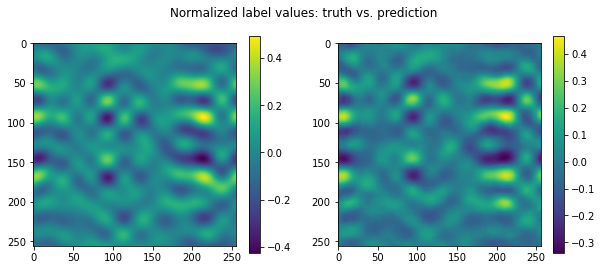

In [32]:
# compare truth and prediction for one or more test samples
print(test_data.shape)
for itest in range(1):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(test_labels[itest, 0, ...])
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(test_predictions[itest, 0,...])
    plt.colorbar()
    plt.suptitle('Normalized label values: truth vs. prediction')

(-1.1, 1.1, -1.1, 1.1)

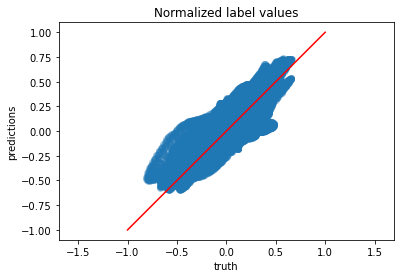

In [33]:
# do the 45-degree plot; close to the diagonal == good
plt.plot((-1, 1), (-1, 1), c='r')
plt.scatter(test_labels.ravel(), test_predictions.ravel(), alpha=0.3)
plt.xlabel('truth')
plt.ylabel('predictions')
plt.title('Normalized label values')
plt.axis('equal')